In [1]:
# Auto loading
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from rotation_3d import tricubic_derivatives,tricubic_interp
from rotation_3d import rot_cost_func_3d
from visualize import plot_cost_func
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
#sept23_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_10.p','rb'))
#sept23_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_8.p','rb'))
#sept23_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_6_4.p','rb'))
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [6]:
from Gauss_Newton import sphere_mask,get_mask_weights,fourier_filter,axis_derivatives,rotate_coords_transformation_m,get_M

Let $V^S$ denote the source volume, and $V^T$ denote the target volume.  We want to find a transformation from source to target so that their sum of squared difference is minimal. The cost function we have chosen is the sum of squared differences between the two volume at each voxel, defined as, 
$$f = \sum\limits_{i}(V^S(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^T)^2,$$ 
where $\boldsymbol{x_i}$ is the voxel location, and $\boldsymbol{d}(\boldsymbol{P})$ is the replacement from source to target given the set of parameters $\boldsymbol{P}$. We need to minimize this cost function with respect to the set of six transformation parameters $\boldsymbol{P}$. 

Gauss-Newton method allows us to find the minimum of a least squared function through iterative procedures. Let 
$$\begin{align}
r_i(\boldsymbol{P}) = V^S(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^T (1)
\end{align}$$

Then the iteration goes as follows,
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s}),$$
where 

$$(\mathbf{J_r})_{ij} = \frac{\partial r_i (\boldsymbol P^{(s)})}{\partial P_j}$$

$$=\frac{\partial r_i (\boldsymbol P^{(s)})}{\partial \boldsymbol{d}(P_j)}\frac{\partial \boldsymbol{d}(P_j)}{\partial P_j}$$

Now the problem boils down to simplifying the computation for the Jacobian. If we take the gradient of $r_i(\boldsymbol{P})$ using equation (1) we get,

$$
\frac{\partial r_i (\boldsymbol{P})}{\partial P_j} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \frac{\partial \boldsymbol{d}(P_j)}{\partial P_j}$$

where $\nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)}$ is the partial derivatives of the source volume at voxel $i$ with respect to the three coordinate directions, which is computed already during tricubic interpolation. Since the displacement between the two volumes are relatively small,  we can model the small rotations as a translation.

$$\boldsymbol{d(\boldsymbol{P})} = \boldsymbol{M}\boldsymbol{P},$$
where

$$
\boldsymbol{M} = 
\begin{bmatrix}
1 & 0 & 0 & 0 & x_3 & -x_2\\
0 & 1 & 0 & -x_3 & 0 & x_1\\
0 & 0 & 1 & x_2 & -x_1 & 0\\
\end{bmatrix}$$

Hence, 
$$\frac{\partial \boldsymbol{d}(P)}{\partial P} = \boldsymbol{M}$$
$$\frac{\partial \boldsymbol{d}(P)}{\partial P_j} = \boldsymbol{M}[:,j]$$
$$\frac{\partial r_i (\boldsymbol{P})}{\partial P_j} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]$$

$$
(\mathbf{J_r})_{ij} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]
$$

Notice that we still need to compute $\nabla_{\boldsymbol{x}}\boldsymbol{V^S}$ at each step for each voxel, which can be very expensive, so to save computation, we can calculate the displacement on the target volume $V^T$. 
Suppose now we pretend to move the target volume to the source volume instead, then
$$f = \sum\limits_{i}(V^T(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^S)^2,$$
and if we follow the steps we will end up with 
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s}),$$
where 
$$(\mathbf{J_r})_{ij} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^T(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]$$
We can now move $V^S$ by $-\boldsymbol{P}$, and continue with the iteration. This way, we only need to compute $\nabla_{\boldsymbol{x}_i}\boldsymbol{V^T(\boldsymbol{x}_i)} $ once, and in every iteration it remains constant.

### Levenberg-Marquardt algorithm
From Gauss-Newton we have 
\begin{align*}
\boldsymbol{P}^{s+1} &= \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s})\\
 \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)(\boldsymbol{P}^{s+1} - \boldsymbol{P}^{s} ) &= \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s})\\
\end{align*}
Applying the Levenberg-Marquardt algorithm we get,
\begin{align*}
  \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} + \lambda \cdot diag(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} ) \right)(\boldsymbol{P}^{s+1} - \boldsymbol{P}^{s} ) &= \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s})\\
  \boldsymbol{P}^{s+1} &= \boldsymbol{P}^{s} -   \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} + \lambda \cdot diag(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} ) \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s})\\
\end{align*}

In [22]:
# Get two volumes to register
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]

In [36]:
%%time
derivatives = axis_derivatives(testVol1)

(32, 32, 32)
CPU times: user 6.9 ms, sys: 997 µs, total: 7.9 ms
Wall time: 7.05 ms


In [37]:
%%time
derivatives_old = axis_derivatives_old(testVol1)

CPU times: user 232 ms, sys: 25.4 ms, total: 257 ms
Wall time: 240 ms


In [31]:
i,j,k = 0,0,0
print derivatives_old[(i,j,k)]*100
print derivatives[j,i,k]*100

[-0.11042264 -0.00695046  0.01119149]
[-0.11042264 -0.00695046  0.01119149]


In [32]:
xx,yy,zz = np.meshgrid(np.linspace(0,31,32),np.linspace(0,31,32),np.linspace(0,31,32))

In [38]:
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            #print i, j, k, xx[i,j,k],yy[i,j,k],zz[i,j,k]
            if not np.allclose(derivatives[j,i,k],derivatives_old[(i,j,k)]):
                print i, j, k

In [908]:
def axis_derivatives(volume):
    shape = volume.shape
    xx,yy,zz = np.meshgrid(np.linspace(0,shape[1]-1,shape[1]),np.linspace(0,shape[0]-1,shape[0]),np.linspace(0,shape[2]-1,shape[2]))
    x1 = xx.astype(int)
    y1 = yy.astype(int)
    z1 = zz.astype(int)

    x0 = x1 - 1
    x2 = x1 + 1
    y0 = y1 - 1
    y2 = y1 + 1
    z0 = z1 - 1
    z2 = z1 + 1

    # wrap around
    x0 = (x0 + shape[1]) % shape[1]
    x2 = (x2 + shape[1]) % shape[1]
    y0 = (y0 + shape[0]) % shape[0]
    y2 = (y2 + shape[0]) % shape[0]
    z0 = (z0 + shape[2]) % shape[2]
    z2 = (z2 + shape[2]) % shape[2] 

    # Wrap around original grid points
    x1 = (x1 + shape[1]) % shape[1]
    y1 = (y1 + shape[0]) % shape[0]
    z1 = (z1 + shape[2]) % shape[2]

    # Compute vector Y from known points
    Y = np.empty([shape[1],shape[0],shape[2],3])
    
    # values of df/dx at each corner.
    Y[:,:,:,0] = ((volume[y1,x1,z2]-volume[y1,x1,z0])/2.)
    # values of df/dy at each corner.
    Y[:,:,:,1] = ((volume[y1,x2,z1]-volume[y1,x0,z1])/2.)
    # values of df/dz at each corner.
    Y[:,:,:,2] = ((volume[y2,x1,z1]-volume[y0,x1,z1])/2.)

    return Y

In [7]:
# Function to compute the derivatives for the target volume
def axis_derivatives_old(volume):
    shape = volume.shape
    tricubic_derivative_dict = {}
    for i in xrange(0,shape[0]):
        for j in xrange(0,shape[1]):
            for k in xrange(0,shape[2]):
                # Take care of boundary conditions
                x1 = i
                y1 = j
                z1 = k
                x0 = x1 - 1
                x2 = x1 + 1
                y0 = y1 - 1
                y2 = y1 + 1
                z0 = z1 - 1
                z2 = z1 + 1
                
                    # Wrap Around
                x0 = (x0 + volume.shape[1]) % volume.shape[1]
                x2 = (x2 + volume.shape[1]) % volume.shape[1]
                y0 = (y0 + volume.shape[0]) % volume.shape[0]
                y2 = (y2 + volume.shape[0]) % volume.shape[0]
                z0 = (z0 + volume.shape[2]) % volume.shape[2]
                z2 = (z2 + volume.shape[2]) % volume.shape[2] 

                # Wrap around original grid points
                x1 = (x1 + volume.shape[1]) % volume.shape[1]
                y1 = (y1 + volume.shape[0]) % volume.shape[0]
                z1 = (z1 + volume.shape[2]) % volume.shape[2]
                
#                 x0 = np.clip(x0, 0, volume.shape[1]-1)
#                 x1 = np.clip(x1, 0, volume.shape[1]-1)
#                 x2 = np.clip(x2, 0, volume.shape[1]-1)
#                 y0 = np.clip(y0, 0, volume.shape[0]-1)
#                 y1 = np.clip(y1, 0, volume.shape[0]-1)
#                 y2 = np.clip(y2, 0, volume.shape[0]-1)
#                 z0 = np.clip(z0, 0, volume.shape[2]-1)
#                 z1 = np.clip(z1, 0, volume.shape[2]-1)
#                 z2 = np.clip(z2, 0, volume.shape[2]-1)

                # Compute vector Y from known points
                Y = np.zeros([3,])

                # values of df/dx at each corner.
                Y[1] = ((volume[y1,x2,z1]-volume[y1,x0,z1])/2.)
                # values of df/dy at each corner.
                Y[0] = ((volume[y2,x1,z1]-volume[y0,x1,z1])/2.)
                # values of df/dz at each corner.
                Y[2] = ((volume[y1,x1,z2]-volume[y1,x1,z0])/2.)

                tricubic_derivative_dict[(i,j,k)] = Y
    return tricubic_derivative_dict

In [1064]:
def rotate_coords_transformation_m(x, y, z, params, ox,oy,oz, k=16.):
    l = np.sqrt(params[3]**2+params[4]**2+params[5]**2)/k
    if(l == 0):
        return (x-params[1],y-params[0],z-params[2])
    s,c = np.sin(l/2.),np.cos(l/2.)
    alpha = c
    beta = s*params[4]/l
    gamma = s*params[3]/l
    delta = s*params[5]/l
    x, y, z = x - ox, y - oy, z - oz
    rotx = (alpha**2+beta**2-gamma**2-delta**2)*x+2*(beta*gamma-alpha*delta)*y+2*(beta*delta+alpha*gamma)*z+ox-params[1]
    roty = (alpha**2-beta**2+gamma**2-delta**2)*y+2*(beta*gamma+alpha*delta)*x+2*(gamma*delta-alpha*beta)*z+oy-params[0]
    rotz = (alpha**2-beta**2-gamma**2+delta**2)*z+2*(gamma*delta+alpha*beta)*y+2*(beta*delta-alpha*gamma)*x+oz-params[2]

    return (rotx,roty,rotz)

In [135]:
def get_M(x1_org,x2_org,x3_org,k=16.):
    x1 = x1_org/k
    x2 = x2_org/k
    x3 = x3_org/k
    M = np.array([[0,0,-1,-x2,x1,0],[0,-1,0,x3,0,-x1],[-1,0,0,0,-x3,x2]])
    return M

In [10]:
def to_degree(radian):
    return radian*180/np.pi

def trace_plot(Ps,res):
    arr = np.array(Ps)
    plt.figure(figsize = [12,4])
    plt.subplot(1,2,1)
    for i in xrange(3):
        plt.plot(arr[:,i]*res,label = 't_%s'%i)
    plt.legend(loc = 'best')
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Translations (mm)', fontsize = 15)
    plt.subplot(1,2,2)
    for j in xrange(3,6):
        plt.plot(to_degree(arr[:,j]),label = 'R_%s'%j)
    plt.legend(loc = 'best')
    plt.suptitle('Trace Plot for the Transformation Parameters',fontsize=18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Rotations (degrees)', fontsize = 15)
    plt.show()
    
def plot_errors(errors):
    plt.plot(errors[1:])
    plt.title('Trace Plot for Errors',fontsize = 18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('SSD Error', fontsize = 15)
    plt.show()
    
def convert_params(params,res):
    print 'translation (in mm):', params[:3]*res
    print 'rotations (in degrees):', params[3:]*180/np.pi
    
def print_results(errors, Ps, res):
    print 'min error: ', errors[-1]
    params = Ps[-1]
    print 'parameters at min error: ', params
    print 'translation (in mm):', params[:3]*res
    print 'rotations (in degrees):', params[3:]*180/np.pi

In [352]:
# Get two volumes to register
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

# Get the mesh_grid points for the volume
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5
derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)
#derivatives = axis_derivatives(testVol1)
#tricubic_cache = tricubic_derivatives(testVol2)

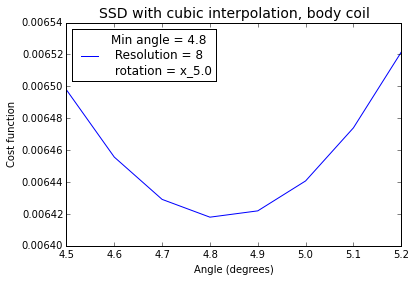

In [353]:
# Test tricubic interpolation on 8mm, x-axis rotation
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

thetas = np.arange(4.5,5.2,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_masked, testVol2_masked, thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

In [10]:
from rotation_3d import X_inv
# compare B matrix
B_inv = np.array(np.memmap('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/BInv.dat',
                           dtype=np.float32,mode='c',shape=(64,64)))
np.sum(X_inv-B_inv)

0.0

In [11]:
ImagePoints = np.array(np.memmap('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/ImagePoints.dat',dtype=np.float32,mode='c',shape=(32,32,32,3)))
ImagePoints.shape

(32, 32, 32, 3)

In [12]:
res = '8'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

In [13]:
print (ImagePoints[:,:,:,1] == xx-15.5).all()
print (ImagePoints[:,:,:,0] == yy-15.5).all()
print (ImagePoints[:,:,:,2] == zz-15.5).all()

True
True
True


In [14]:
fourierPoints = np.array(np.memmap('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/fourierPoints.dat',dtype=np.float32,mode='c',shape=(32,32,32,3)))
fourierPoints.shape

(32, 32, 32, 3)

In [15]:
testvol1 = np.array(np.memmap('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/filteredImgRotX05to25TransZRep0.dat',
                              dtype=np.float32,mode='c',shape=(32,32,32)))

In [938]:
def window(n, radius, d=0.4):
    tmp = float(n)/radius - 0.75
    if tmp < 0:
        return 1
    else:
        if((tmp/d > -0.5) and (tmp/d <0.5)):
            return np.cos((np.pi*(tmp/d)))
        else:
            return 0
def sphere_mask(volume, radius, d=0.4):
    origin = np.array([(x - 1.0) / 2.0 for x in volume.shape])
    mask_frequency = np.array([[[window(np.linalg.norm(np.array([x,y,z]) - origin), radius, d) 
                                 for x in range(volume.shape[0])] for y in range(volume.shape[1])] 
                               for z in range(volume.shape[2])])

    return mask_frequency * volume

def get_mask_weights(volume, radius, d=0.4):
    origin = np.array([(x - 1.0) / 2.0 for x in volume.shape])
    mask_frequency = np.array([[[window(np.linalg.norm(np.array([x,y,z]) - origin), radius, d) 
                                 for x in range(volume.shape[0])] for y in range(volume.shape[1])] 
                               for z in range(volume.shape[2])])

    return mask_frequency

def fourier_filter(vol, rad):
    return abs(fft.ifftn(fft.ifftshift(sphere_mask(fft.fftshift(fft.fftn(vol)),rad,d=0.375))))

In [ ]:
x = np.linspace(0,16,16)
y = [window(i,16,0.4) for i in x]
plt.plot(x,y)
plt.ylim([0,1.1])
plt.show()

In [17]:
rot_ax = 'x'
res = '8'
rad = res_to_rad(res)
print rad
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol1_filtered = fourier_filter(testVol1,rad)

16


In [18]:
np.allclose(testVol1_filtered,testvol1,1e-5,1e-3)

True

In [20]:
np.max(abs(testVol1_filtered-testvol1))

0.00071859409212110461

In [21]:
ImagePointWeights = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/ImagePointWeights.dat', 
        dtype=np.float32, mode='c', shape=(32768)))

In [22]:
mask_weights = get_mask_weights(testvol1,16).reshape([testvol1.shape[1],testvol1.shape[0],testvol1.shape[2],1])

In [23]:
np.allclose(ImagePointWeights,mask_weights.ravel())

True

In [ ]:
{1, 3, 9, 27, 2, 6, 18, 54, 4, 12, 36, 108, 8, 24, 72, 216, 1, 3, 9, \
27, 2, 6, 18, 54, 4, 12, 36, 108, 8, 24, 72, 216, 1, 3, 9, 27, 2, 6, \
18, 54, 4, 12, 36, 108, 8, 24, 72, 216, 1, 3, 9, 27, 2, 6, 18, 54, 4, \
12, 36, 108, 8, 24, 72, 216}

In [581]:
from rotation_3d import get_target_Y
Y = get_target_Y(1,2,3)
print Y

[[   1.    3.    9.   27.    2.    6.   18.   54.    4.   12.   36.  108.
     8.   24.   72.  216.    1.    3.    9.   27.    2.    6.   18.   54.
     4.   12.   36.  108.    8.   24.   72.  216.    1.    3.    9.   27.
     2.    6.   18.   54.    4.   12.   36.  108.    8.   24.   72.  216.
     1.    3.    9.   27.    2.    6.   18.   54.    4.   12.   36.  108.
     8.   24.   72.  216.]]


#### **Step 1: Compare derivatives of image 1 with respect to the coordinate axes **

In [15]:
img1Derivs = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img1Derivs.dat', dtype=np.float32, mode='c', shape=(3,32,32,32)))
img2Derivs = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img2Derivs.dat',dtype=np.float32,mode='c',shape=(3,32,32,32)))

In [162]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(img1Derivs[:,i,j,k], -1.*derivatives[(j,i,k)]):
                count += 1
                print i,j,k
print count

0


In [163]:
derivatives_vol2 = axis_derivatives(testVol2)
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(img2Derivs[:,i,j,k], -1.*derivatives_vol2[(j,i,k)]):
                count += 1
                print i,j,k
print count

0


**Step 2: Compare M Tensor and img1Gradiaent**

In [59]:
img1GradP = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img1GradP.dat', dtype=np.float32, mode='c', shape=(32,32,32,6)))
MTensor = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/MTensor.dat',dtype=np.float32,mode='c',shape=(32,32,32,6,3)))

In [105]:
MT = np.empty([32,32,32,6,3])
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            M = get_M(yy[i,j,k]-15.5,xx[i,j,k]-15.5,zz[i,j,k]-15.5)
            MT[i,j,k,:,:] = M.T

In [164]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MTensor[i,j,k,:,:], MT[i,j,k,:,:]):
                count += 1
                print i,j,k
print count

0


In [165]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MT[i,j,k,:,:].dot(-derivatives[j,i,k]),img1GradP[i,j,k,:],1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [24]:
MTensor = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/MTensor.dat',
        dtype=np.float32,mode='c',shape=(32,32,32,6,3)))

In [25]:
MT = np.empty([32,32,32,6,3])
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            M = get_M(yy[i,j,k]-15.5,xx[i,j,k]-15.5,zz[i,j,k]-15.5,1)
            MT[i,j,k,:,:] = M.T

In [26]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MTensor[i,j,k,:,:], MT[i,j,k,:,:]):
                count += 1
                print i,j,k
print count

0


In [1267]:
derives1 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/derives1.dat', 
        dtype=np.float32, mode='c', shape=(3,32,32,32)))

In [1268]:
myderives1 = axis_derivatives(testvol1)

In [1270]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(derivatives[i,j,k],derives1[:,i,j,k],1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [949]:
img1Derivs = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/ImageDerivs.dat', 
        dtype=np.float32, mode='c', shape=(6,32,32,32)))

In [950]:
derivatives = axis_derivatives(testvol1)

In [951]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MT[i,j,k,:,:].dot(derivatives[i,j,k]),img1Derivs[:,i,j,k],1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [27]:
WeightedImageDerivs = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/WeightedImageDerivs.dat', 
        dtype=np.float32, mode='c', shape=(6,32,32,32)))

In [585]:
WeightedImageDerivs.shape

(6, 32, 32, 32)

In [28]:
derivatives_masked = axis_derivatives(sphere_mask(testvol1,rad))

In [29]:
derivatives = axis_derivatives(testvol1)
derivatives.shape

(32, 32, 32, 3)

In [30]:
count = 0
masked_derivatives = np.empty(derivatives.shape)
idx = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            masked_derivatives[i,j,k] = derivatives[i,j,k]*ImagePointWeights[idx]
            idx += 1

In [31]:
mm1 = (mask_weights*derivatives)

In [32]:
count = 0
idx = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(masked_derivatives[i,j,k],mm1[i,j,k]):
                count += 1
                print i, j, k
            idx += 1
print count

0


In [33]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(derivatives_masked[i,j,k],masked_derivatives[i,j,k]):
                count += 1
                #print i, j, k
print count

11534


In [34]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MT[i,j,k,:,:].dot(masked_derivatives[i,j,k]),WeightedImageDerivs[:,i,j,k]):
                count += 1
                #print i,j,k
print count

0


**Step 3: Compare JTransJ and JTransr**

In [127]:
JTransJ = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/JTransJ.dat',dtype=np.float32,mode='c',shape=(6,6)))

In [189]:
jTj = np.zeros([6,6])
jTr = np.zeros([6,1])
r = testVol2-testVol1

for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            tmp = (MT[i,j,k,:,:].dot(-derivatives[j,i,k])).reshape([1,6])
            jTj += tmp.T.dot(tmp)
            jTr -= tmp.T*(r[i,j,k])

In [190]:
np.allclose(jTj,JTransJ)

True

In [191]:
jTr

array([[-0.05516286],
       [-0.01742106],
       [ 0.00436957],
       [-0.07831883],
       [ 0.16866634],
       [-0.49359507]])

In [194]:
np.linalg.solve(jTj,jTr)

array([[-0.11947555],
       [-0.04306539],
       [ 0.02137844],
       [ 0.00104204],
       [-0.00155372],
       [-0.04679049]])

In [36]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testvol2 = np.zeros(testvol1.shape)
testvol2[1:,:,:] = testvol1[:31,:,:]
testvol2[0,:,:] = testvol1[31,:,:]

In [37]:
vol2_dervs = axis_derivatives(testvol2)

In [38]:
%%time
vol1_coeffs = tricubic_derivatives(testvol1)

CPU times: user 50.9 s, sys: 844 ms, total: 51.7 s
Wall time: 51.7 s


In [39]:
TargetImgCoeffs = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/TargetImgCoeffs.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32,64)))
WeightedMovingImgGradP = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/WeightedMovingImgGradP.dat', 
        dtype=np.float32, mode='c', shape=(32768,6)))
Bvec = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/Bvec.dat', 
        dtype=np.float32, mode='c', shape=(64,32,32,32)))

In [40]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            #tmp = X_inv.dot(vol1_coeffs[i,j,k])
            if not np.allclose(Bvec[:,i,j,k],vol1_coeffs[i,j,k]):
                count += 1
                print i,j,k
print count

0


In [41]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            tmp = X_inv.dot(vol1_coeffs[i,j,k])
            if not np.allclose(TargetImgCoeffs[i,j,k,:],tmp,1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [919]:
derivatives_masked = axis_derivatives(sphere_mask(testvol2,rad))

In [920]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MT[i,j,k,:,:].dot(derivatives[i,j,k]),img1Derivs[:,i,j,k],1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [542]:
interpGridPoints = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/interpGridPoints_test.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32,3)))

In [543]:
transPoints = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/transPoints_test.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32,3)))

In [142]:
print (interpGridPoints[:,:,:,0]==yy+1).all()
print (interpGridPoints[:,:,:,1]==xx+1).all()
print (interpGridPoints[:,:,:,2]==zz+1).all()

True
True
True


In [151]:
print (transPoints[:,:,:,0]+15.5==yy).all()
print (transPoints[:,:,:,1]+15.5==xx).all()
print (transPoints[:,:,:,2]+15.5==zz).all()

True
True
True


In [281]:
# Get rotation matrix from axis-angle rotation
def rotation_matrix_fromq(theta, ui, uj, uk):
    '''
    theta: angle in degrees
    '''
    theta = to_radian(theta)
    c = np.cos(theta)
    s = np.sin(theta)
    rotMatrix = np.zeros([3,3])
    
    if (ui**2 + uj**2 + uk**2 != 1):
        norm = np.sqrt(ui**2 + uj**2 + uk**2)
        ui = ui/norm
        uj = uj/norm
        uk = uk/norm
        
    rotMatrix[0][0] = c + ui**2*(1-c)
    rotMatrix[0][1] = ui*uj*(1-c) - uk*s
    rotMatrix[0][2] = ui*uk*(1-c) + uj*s

    rotMatrix[1][0] = uj*ui*(1-c) + uk*s
    rotMatrix[1][1] = c + uj**2*(1-c)
    rotMatrix[1][2] = uj*uk*(1-c) - ui*s

    rotMatrix[2][0] = uk*ui*(1-c) - uj*s
    rotMatrix[2][1] = uk*uj*(1-c) + ui*s
    rotMatrix[2][2] = c + uk**2*(1-c)
    
    return rotMatrix

In [455]:
def rotate_coords_transformation_matrix(params):
    rotMatrix = np.identity(3)
    l = np.sqrt(params[3]**2+params[4]**2+params[5]**2)
    if(l == 0):
        return rotMatrix
    s,c = np.sin(l/2.),np.cos(l/2.)
    alpha = c
    beta = s*params[3]/l
    gamma = s*params[4]/l
    delta = s*params[5]/l

    rotMatrix[0][0] = alpha**2+beta**2-gamma**2-delta**2
    rotMatrix[0][1] = 2*(beta*gamma-alpha*delta)
    rotMatrix[0][2] = 2*(beta*delta+alpha*gamma)

    rotMatrix[1][0] = 2*(beta*gamma+alpha*delta)
    rotMatrix[1][1] = alpha**2-beta**2+gamma**2-delta**2
    rotMatrix[1][2] = 2*(gamma*delta-alpha*beta)

    rotMatrix[2][0] = 2*(beta*delta-alpha*gamma)
    rotMatrix[2][1] = 2*(gamma*delta+alpha*beta)
    rotMatrix[2][2] = alpha**2-beta**2-gamma**2+delta**2
    
    y, x, z = xx - ox- p[1], yy - oy- p[0], zz - oz- p[2]
    dest_x1 = (R[0][0]*x + R[0][1]*y + R[0][2]*z)
    dest_y1 = (R[1][0]*x + R[1][1]*y + R[1][2]*z)
    dest_z1 = (R[2][0]*x + R[2][1]*y + R[2][2]*z)  
    
    dest_x1 = (dest_x1 + ox + 32) % 32 
    dest_y1 = (dest_y1 + oy + 32) % 32
    dest_z1 = (dest_z1 + oz + 32) % 32
    
    return rotMatrix

In [544]:
from Gauss_Newton import rotate_coords_transformation_m
#p=[0,0,0,0,0,0]
#p = [1.00706,0.0069858,0.0278668,0.0012846,-0.00053813,0.00100747]
p = [1.0070618260934048, 0.006985800340610231, 0.027866808064760742, 
     0.001284595171892761, -0.0005381302579664845, 0.0010074739466495368]
#p = [0.999983,0.00100333,0.000229423,-0.0000293456,9.68796e-6,-0.0000120867]
#p=[0,0,0,0,0,0]
ox,oy,oz=15.5,15.5,15.5
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, p, ox, oy, oz,1)

In [533]:
p1 = [1.0070618260934048, 0.006985800340610231, 0.027866808064760742, 
     0.001284595171892761, -0.0005381302579664845, 0.0010074739466495368]
p2 = [1.00706183e+00,6.98579957e-03,2.78668081e-02,1.28459517e-03,-5.38130404e-04,1.00747391e-03]

In [545]:
counter=1
dest_x0,dest_y0,dest_z0 = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/dest_xyz_%s.p'%counter,'rb'))

In [546]:
print np.allclose(dest_x0,dest_x)
print np.allclose(dest_y0,dest_y)
print np.allclose(dest_z0,dest_z)

True
True
True


In [439]:
theta = np.sqrt(p[3]**2+p[4]**2+p[5]**2)
RR = np.linalg.inv(rotation_matrix_fromq(theta,p[3],p[4],p[5]))

In [456]:
R = rotate_coords_transformation_matrix(p)
print R
R = np.linalg.inv(R)
print R
y, x, z = xx - ox- p[1], yy - oy- p[0], zz - oz- p[2]
dest_x1 = (R[0][0]*x + R[0][1]*y + R[0][2]*z)
dest_y1 = (R[1][0]*x + R[1][1]*y + R[1][2]*z)
dest_z1 = (R[2][0]*x + R[2][1]*y + R[2][2]*z)

[[  9.99999348e-01  -1.00781909e-03  -5.37482895e-04]
 [  1.00712781e-03   9.99998667e-01  -1.28486562e-03]
 [  5.38777091e-04   1.28432346e-03   9.99999030e-01]]
[[  9.99999348e-01   1.00712781e-03   5.38777091e-04]
 [ -1.00781909e-03   9.99998667e-01   1.28432346e-03]
 [ -5.37482895e-04  -1.28486562e-03   9.99999030e-01]]


In [465]:
print np.allclose(transPoints[:,:,:,0],dest_x1)
print np.allclose(transPoints[:,:,:,1],dest_y1)
print np.allclose(transPoints[:,:,:,2],dest_z1)

False
False
False


In [442]:
dest_x1 = (dest_x1 + ox + 32) % 32 + 1
dest_y1 = (dest_y1 + oy + 32) % 32 + 1
dest_z1 = (dest_z1 + oz + 32) % 32 + 1

In [554]:
print np.allclose(interpGridPoints[:,:,:,0],dest_y0+1)
print np.allclose(interpGridPoints[:,:,:,1],dest_x0+1)
print np.allclose(interpGridPoints[:,:,:,2],dest_z0+1)

True
True
True


In [472]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(interpGridPoints[i,j,k,0],dest_y[i,j,k]):
                count += 1
                print i, j, k,interpGridPoints[i,j,k,0],(dest_y[i,j,k])
print count

0


In [565]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.floor(interpGridPoints[i,j,k,0]) == np.floor(dest_y[i,j,k]+1):
                count += 1
                print i, j, k,interpGridPoints[i,j,k,0],(dest_y[i,j,k])
print count

0 26 9 32.0 30.9999996827
1 26 9 33.0 31.9999990304
2


In [473]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(interpGridPoints[i,j,k,1],dest_x[i,j,k]):
                count += 1
                print i, j, k,interpGridPoints[i,j,k,1],(dest_x[i,j,k])
print count

0


In [566]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.floor(interpGridPoints[i,j,k,1]) == np.floor(dest_x[i,j,k]+1):
                count += 1
                print i, j, k,interpGridPoints[i,j,k,1],(dest_x[i,j,k])
print count

14 16 19 17.0 15.9999995496
1


In [474]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(interpGridPoints[i,j,k,2],dest_z[i,j,k]):
                count += 1
                print i, j, k,interpGridPoints[i,j,k,2],(dest_z[i,j,k])
print count

0


In [568]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.floor(interpGridPoints[i,j,k,2]) == np.floor(dest_z[i,j,k]+1):
                count += 1
                print i, j, k,interpGridPoints[i,j,k,2],(dest_z[i,j,k])
print count

0


In [1539]:
dest_y[:,0,0]

array([ 30.96898865,  31.968988  ,   0.96898735,   1.96898669,
         2.96898604,   3.96898539,   4.96898474,   5.96898408,
         6.96898343,   7.96898278,   8.96898213,   9.96898147,
        10.96898082,  11.96898017,  12.96897952,  13.96897887,
        14.96897821,  15.96897756,  16.96897691,  17.96897626,
        18.9689756 ,  19.96897495,  20.9689743 ,  21.96897365,
        22.96897299,  23.96897234,  24.96897169,  25.96897104,
        26.96897039,  27.96896973,  28.96896908,  29.96896843])

In [1540]:
interpGridPoints[:,:,:,0][:,0,0]

array([ 31.96896553,  32.96896362,   1.9689641 ,   2.96896338,
         3.96896267,   4.96896219,   5.96896124,   6.96896076,
         7.96896029,   8.96895981,   9.96895885,  10.9689579 ,
        11.9689579 ,  12.96895695,  13.96895599,  14.96895599,
        15.96895504,  16.96895409,  17.96895409,  18.96895218,
        19.96895218,  20.96895218,  21.96895027,  22.96895027,
        23.96895027,  24.96894836,  25.96894836,  26.96894836,
        27.96894646,  28.96894646,  29.96894646,  30.96894455], dtype=float32)

In [1541]:
dest_z[0,0,:]

array([  3.94706030e-04,   1.00039374e+00,   2.00039277e+00,
         3.00039180e+00,   4.00039083e+00,   5.00038986e+00,
         6.00038889e+00,   7.00038792e+00,   8.00038695e+00,
         9.00038598e+00,   1.00003850e+01,   1.10003840e+01,
         1.20003831e+01,   1.30003821e+01,   1.40003811e+01,
         1.50003802e+01,   1.60003792e+01,   1.70003782e+01,
         1.80003772e+01,   1.90003763e+01,   2.00003753e+01,
         2.10003743e+01,   2.20003734e+01,   2.30003724e+01,
         2.40003714e+01,   2.50003705e+01,   2.60003695e+01,
         2.70003685e+01,   2.80003675e+01,   2.90003666e+01,
         3.00003656e+01,   3.10003646e+01])

In [1542]:
interpGridPoints[:,:,:,2][0,0,:]

array([  1.00094485,   2.0009439 ,   3.00094295,   4.00094223,
         5.0009408 ,   6.00093985,   7.00093889,   8.00093842,
         9.00093746,  10.00093651,  11.00093555,  12.0009346 ,
        13.00093365,  14.00093269,  15.00093174,  16.00093079,
        17.00092888,  18.00092888,  19.00092697,  20.00092697,
        21.00092506,  22.00092506,  23.00092316,  24.00092316,
        25.00092125,  26.00092125,  27.00091934,  28.00091934,
        29.00091743,  30.00091743,  31.00091553,  32.00091553], dtype=float32)

In [1567]:
print np.allclose(interpGridPoints[:,:,:,0].astype(int),(dest_y+1).astype(int))
print np.allclose(interpGridPoints[:,:,:,1].astype(int),(dest_x+1).astype(int))
print np.allclose(interpGridPoints[:,:,:,2].astype(int),(dest_z+1).astype(int))

False
False
False


In [7]:
testvol1 = np.array(np.memmap('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/filteredImgRotX05to25TransZRep0.dat',
                              dtype=np.float32,mode='c',shape=(32,32,32)))

In [8]:
# Get two volumes to register
res = '8'
rad = res_to_rad(res)
testVol2 = testvol1.copy()
testVol1 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/movingImg.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))

# mask the moving volume
testVol1_masked = sphere_mask(testVol1,rad)

#derivatives = axis_derivatives(testVol1)
#mask_weights = get_mask_weights(testvol1,rad).reshape([testvol1.shape[1],testvol1.shape[0],testvol1.shape[2],1])
#masked_derivatives = mask_weights*derivatives
from Gauss_Newton import get_gradient_P
gradP = get_gradient_P(testVol1)
gradP.shape
tricubic_coeffs = tricubic_derivatives(testVol2)

# Precompute some information for gd
volume_shape = testVol2.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

In [16]:
%%time
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            a=1

CPU times: user 5.25 ms, sys: 3.85 ms, total: 9.1 ms
Wall time: 5.99 ms


0 1 2 3 4 Converged in 4 iterations!


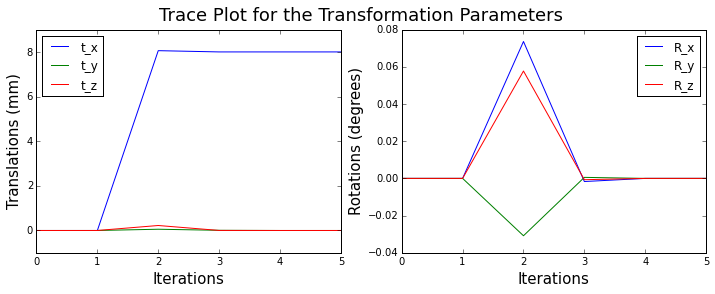

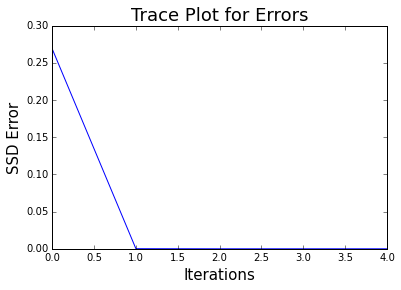

min error:  1.34596208331e-18
parameters at min error:  [  1.00000000e+00   2.88973704e-09  -4.29324484e-10   2.04518133e-12
   2.06969127e-13   2.38352516e-15]
translation (in mm): [  8.00000000e+00   2.31178963e-08  -3.43459587e-09]
rotations (in degrees): [  1.17180259e-10   1.18584575e-11   1.36565932e-13]
CPU times: user 1.54 s, sys: 32.3 ms, total: 1.57 s
Wall time: 1.59 s


In [59]:
%%time
from Gauss_Newton import Gauss_Newton,print_results
P_s = np.array([0,0,0,0,0,0])
errors, Ps = Gauss_Newton(testVol1_masked,gradP,testVol2,tricubic_coeffs, mask=True, 
                          P_initial = P_s,divide_factor = 1., alpha = 1., max_iter = 10,decrease_factor = 0.25)
print_results(errors, Ps, 8)

In [60]:
%%time
tricubic_coeffs = tricubic_derivatives(testVol2)

CPU times: user 49.5 s, sys: 282 ms, total: 49.8 s
Wall time: 50 s


In [604]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(TargetImgCoeffs[i,j,k,:],tricubic_coeffs[i,j,k],1e-5,1e-7):
                count += 1
                #print i,j,k
print count

0


In [54]:
weights = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/mask_weights.p','rb'))
weights.shape

(32, 32, 32)

In [55]:
print np.allclose(mask_weights.ravel(),weights.ravel())
print np.allclose(mask_weights.ravel(),ImagePointWeights)
print np.allclose(weights.ravel(),ImagePointWeights)

True
True
True


In [56]:
# Get two volumes to register
testvol2 = np.zeros(testvol1.shape)
testvol2[1:,:,:] = testvol1[:31,:,:]
testvol2[0,:,:] = testvol1[31,:,:]

In [57]:
(testvol2==testVol1).all()

True

In [58]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(Bvec[:,i,j,k],tricubic_coeffs[i,j,k]):
                count += 1
                print i,j,k
print count

0


In [59]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            tmp = X_inv.dot(tricubic_coeffs[i,j,k])
            if not np.allclose(TargetImgCoeffs[i,j,k,:],tmp,1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [60]:
WeightedMovingImgGradP = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/WeightedMovingImgGradP.dat', 
        dtype=np.float32, mode='c', shape=(32768,6)))

In [10]:
from Gauss_Newton import get_gradient_P
gradP = get_gradient_P(testVol1)
gradP.shape

(6, 32768)

In [601]:
count = 0
idx = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(gradP[:,idx],WeightedMovingImgGradP[idx]):
                count += 1
                #print i,j,k
            idx += 1
print count

0


In [236]:
count = 0
idx = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MT[i,j,k,:,:].dot(masked_derivatives[i,j,k]),WeightedMovingImgGradP[idx],1e-5,1e-3):
                count += 1
                #print i,j,k
            idx += 1
print count

0


In [62]:
count = 0
idx = 0
Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            M = get_M(yy[i,j,k]-oy,xx[i,j,k]-ox,zz[i,j,k]-oz,1)
            if not np.allclose(M.T,MT[i,j,k,:,:]):
                count += 1
print count

0


In [63]:
count = 0
idx = 0
Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            M = get_M(yy[i,j,k]-oy,xx[i,j,k]-ox,zz[i,j,k]-oz,1)
            for ii in xrange(6):
                Jr[idx,ii] = masked_derivatives[i,j,k].dot(M[:,ii])
            idx += 1

In [64]:
count = 0
idx = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(Jr[idx],WeightedMovingImgGradP[idx],1e-5,1e-3):
                count += 1
                #print i,j,k
            idx += 1
print count

0


In [611]:
from Gauss_Newton import rotate_coords_transformation_m
P_s = np.array([0,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz,1.)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_coeffs,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
#print cf_ssd(dest,testVol1)
print cf_ssd(sphere_mask(dest,16),testVol1_masked)

0.268717059017


In [625]:
%%time
from Gauss_Newton import rotate_coords_transformation_m
P_s = np.array([1,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz,1.)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_coeffs,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1)

0.0
CPU times: user 2.38 s, sys: 24.2 ms, total: 2.4 s
Wall time: 2.41 s


In [67]:
R_0 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/R_0.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
R_1 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/R_1.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
R_2 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/R_2.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
R_3 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/R_3.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
R_4 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/R_4.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))

In [68]:
np.sum(R_0**2)

0.26871705

In [69]:
np.sum(R_4**2)

1.3459606e-18

In [556]:
interp_0 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/interp_0.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
interp_1 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/interp_1.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
interp_2 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/interp_2.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
interp_3 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/interp_3.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))
interp_4 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/interp_4.dat', 
        dtype=np.float32, mode='c', shape=(32,32,32)))

In [72]:
flatR_0 = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/flatR_0.p','rb'))
flatR_1 = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/flatR_1.p','rb'))
flatR_2 = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/flatR_2.p','rb'))
flatR_3 = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/flatR_3.p','rb'))
flatR_4 = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/flatR_4.p','rb'))

In [73]:
myJr = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/myJr_0.p','rb'))

In [74]:
count = 0
idx = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(Jr[idx],myJr[idx],1e-5,1e-3):
                count += 1
            idx += 1
print count

0


In [75]:
DeltaP_0 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/DeltaP_0.dat', 
        dtype=np.float32, mode='c', shape=(6)))
DeltaP_1 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/DeltaP_1.dat', 
        dtype=np.float32, mode='c', shape=(6)))
DeltaP_2 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/DeltaP_2.dat', 
        dtype=np.float32, mode='c', shape=(6)))
DeltaP_3 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/DeltaP_3.dat', 
        dtype=np.float32, mode='c', shape=(6)))
DeltaP_4 = np.array(np.memmap(
        '/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/DeltaP_4.dat', 
        dtype=np.float32, mode='c', shape=(6)))

In [76]:
for i in xrange(6):
    print DeltaP_0[i],
print
for i in xrange(6):
    print DeltaP_1[i],
print
for i in xrange(6):
    print DeltaP_2[i],
print
for i in xrange(6):
    print DeltaP_3[i],
print 
for i in xrange(6):
    print DeltaP_4[i],

-1.00706 -0.0069858 -0.0278668 -0.0012846 0.00053813 -0.00100747
0.00707877 0.00598247 0.0276374 0.00131394 -0.000547818 0.00101956
-1.69421e-05 0.00101577 0.000239122 -2.93518e-05 9.68748e-06 -1.20895e-05
2.04461e-09 -1.24385e-05 -9.69815e-06 6.20435e-09 4.74544e-10 2.84345e-09
-2.21691e-12 2.88973e-09 -4.29119e-10 2.04534e-12 2.07062e-13 2.57895e-15


In [1512]:
np.zeros(6)-DeltaP_0

array([  1.00706184e+00,   6.98580034e-03,   2.78668087e-02,
         1.28459523e-03,  -5.38130233e-04,   1.00747391e-03])

In [557]:
counter = 0
dest = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/dest_%s.p'%counter,'rb'))
print np.allclose(interp_0, dest)

True


In [558]:
counter = 1
dest = pickle.load(open('/Users/zyzdiana/Downloads/GaussNewtonInterp_8mm-2/dest_%s.p'%counter,'rb'))
print np.allclose(interp_1, dest)

False


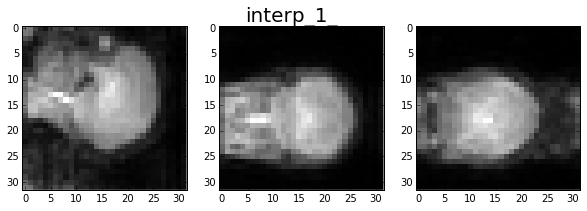

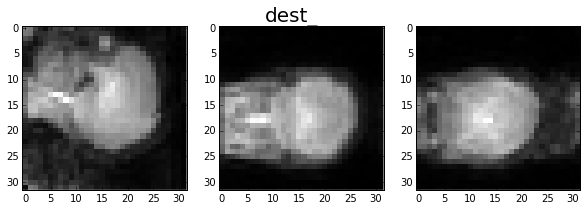

In [561]:
from visualize import plot_volume
plot_volume(interp_1,'interp_1')
plot_volume(dest,'dest')

0 1 2 3 4 Converged in 4 iterations!


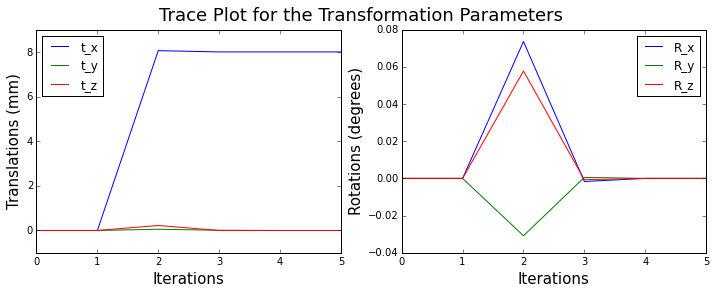

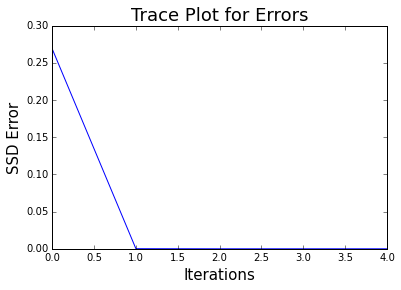

min error:  1.34441186785e-18
parameters at min error:  [  1.00000000e+00   2.89068905e-09  -4.11051955e-10   2.02086256e-12
   2.04137987e-13   2.38451170e-15]
translation (in mm): [  8.00000000e+00   2.31255124e-08  -3.28841564e-09]
rotations (in degrees): [  1.15786896e-10   1.16962451e-11   1.36622457e-13]


In [63]:
from Gauss_Newton import Gauss_Newton,print_results
P_s = np.array([0,0,0,0,0,0])
errors, Ps = Gauss_Newton(testVol1_masked,gradP,testVol2,tricubic_coeffs, mask=True, 
                          P_initial = P_s,divide_factor = 16., alpha = 1., max_iter = 10,decrease_factor = 0.25)
print_results(errors, Ps, 8)

##3D Plot

In [216]:
t0 = np.arange(-2,2,0.1)
r0 = np.arange(-0.1,0.1,0.005)
cost = []
for ii in xrange(len(t0)):
    print ii,
    P_s = np.array([t0[ii],0,0,r0[ii],0,0])
    dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz,1.)
    dest = np.empty(volume_shape)
    for i in xrange(volume_shape[0]):
        for j in xrange(volume_shape[1]):
            for k in xrange(volume_shape[2]):
                dest[i,j,k] = tricubic_interp(volume_shape,tricubic_coeffs,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
    cost.append(cf_ssd(sphere_mask(dest,rad),testVol1_masked))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39


In [32]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)

# Get the mesh_grid points for the volume
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

In [396]:
# Get two volumes to register
rot_ax = 'z'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)

# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

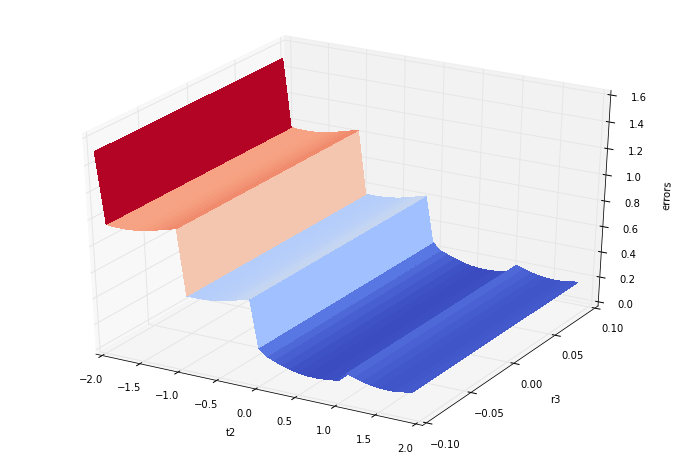

In [219]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
Ps = []
for ii in xrange(len(t0)):
    Ps.append(np.array([t0[ii],0,0,r0[ii],0,0]))
params_array = np.array(Ps)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
X = params_array[:,0]
Y = params_array[:,3]
X, Y = np.meshgrid(X, Y)
Z = np.array(cost)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('t2')
ax.set_ylabel('r3')
ax.set_zlabel('errors')

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [221]:
t3 = np.arange(-2,2,0.1)
r3 = np.arange(-0.1,0.1,0.005)
cost = []
for ii in xrange(len(t0)):
    print ii,
    P_s = np.array([0,0,t3[ii],0,0,r3[ii]])
    dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz,1.)
    dest = np.empty(volume_shape)
    for i in xrange(volume_shape[0]):
        for j in xrange(volume_shape[1]):
            for k in xrange(volume_shape[2]):
                dest[i,j,k] = tricubic_interp(volume_shape,tricubic_coeffs,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
    cost.append(cf_ssd(sphere_mask(dest,rad),testVol1_masked))

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39


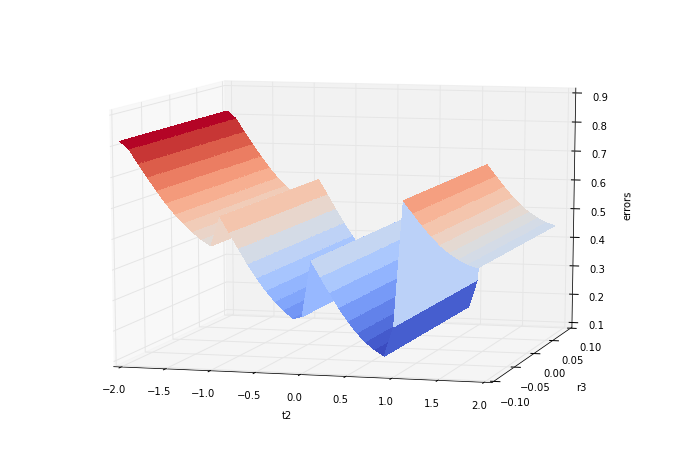

In [235]:
#some code taken from https://github.com/jakevdp/ESAC-stats-2014
from IPython.html.widgets import interact
from mpl_toolkits import mplot3d

def plot_3D(X, Y, Z, elev=30, azim=30):
    fig = plt.figure(figsize=[12,8])
    ax = fig.gca(projection='3d')
    #ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50)
    #ax.view_init(elev=elev, azim=azim)
    p=ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('t2')
    ax.set_ylabel('r3')
    ax.set_zlabel('errors')
    #fig.colorbar(p)

#set azim to -77, elev to 24
def plotter(elev, azim):
    return plot_3D(X, Y, Z, elev=elev, azim=azim)
interact(plotter, elev=[-30, 30], azim=(-180, 180));

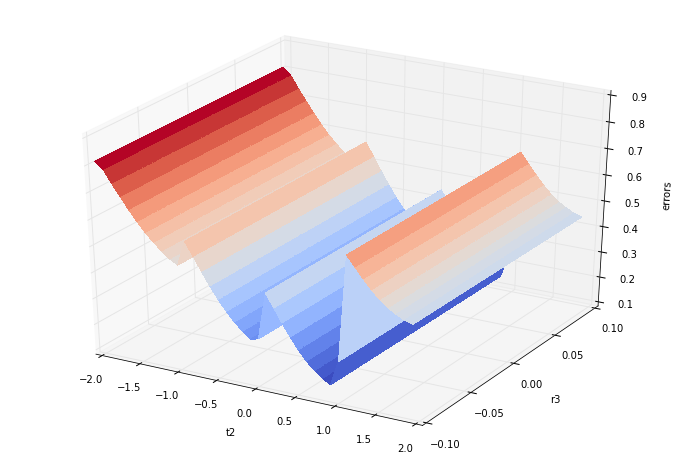

In [227]:
Ps = []
for ii in xrange(len(t0)):
    Ps.append(np.array([0,0,t3[ii],0,0,r3[ii]]))
params_array = np.array(Ps)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
X = params_array[:,2]
Y = params_array[:,5]
X, Y = np.meshgrid(X, Y)
Z = np.array(cost)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('t2')
ax.set_ylabel('r3')
ax.set_zlabel('errors')

plt.show()

In [397]:
P_s = np.array([0,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.0125651922879


In [398]:
P_s = np.array([0,0,0,0,0,-to_radian(5)])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.00505054067392


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

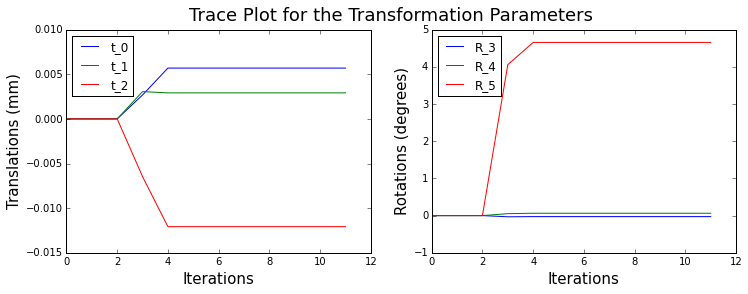

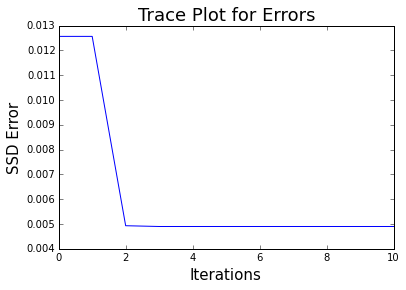

 min error:  0.00489957817124
parameters at min error:  [ 0.00071113  0.00036421 -0.00150915 -0.00047599  0.0010994   0.08125279]
translation (in mm): [ 0.00568901  0.0029137  -0.01207319]
rotations (in degrees): [-0.02727244  0.06299093  4.65544199]


In [399]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked)
print_results(errors_z, Ps_z, 8)

In [ ]:
# Get two volumes to register
rot_ax = 'z'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)

# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

In [ ]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked,divide_factor = 10.)
print_results(errors_z, Ps_z, 8)

In [170]:
# Get two volumes to register
rot_ax = 'y'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)

# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

In [123]:
P_s = np.array([0,0,0,0,-to_radian(5),0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.00469517912784


In [ ]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked)
print_results(errors_z, Ps_z, 8)

In [10]:
def get_volume(res, rot_ax, rang_id, rot_angle, mask = True):
    if('10' in res): dict_ = oct13_dict_10
    if('8' in res): dict_ = oct13_dict_8
    if('6_4' in res): dict_ = oct13_dict_6_4
    rad = res_to_rad(res)
    vol = dict_[rot_ax][axes_dict[rot_ax]][ranges[rang_id]][rot_angle]
    vol_filtered = abs(fft.ifftn(fft.ifftshift(sphere_mask(fft.fftshift(fft.fftn(vol)),rad))))
    if(mask):
        return sphere_mask(vol_filtered,rad)
    else:
        return vol_filtered

In [14]:
%%time
# Calculate the radius for masking
res = '8'
rot_ax = 'x'

# Get two volumes to register
testVol1_rot = get_volume(res,rot_ax,1,(0.0,5))
testVol2_rot = get_volume(res,rot_ax,1,(5.0,5))

vol1_dervs_rot = axis_derivatives(testVol1_rot)
vol2_dervs_rot = tricubic_derivatives(testVol2_rot)

CPU times: user 16.1 s, sys: 332 ms, total: 16.4 s
Wall time: 16.4 s


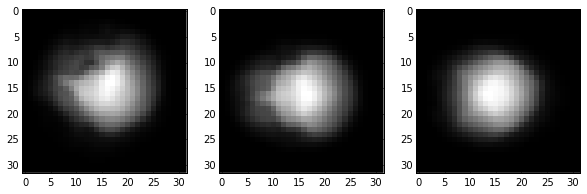

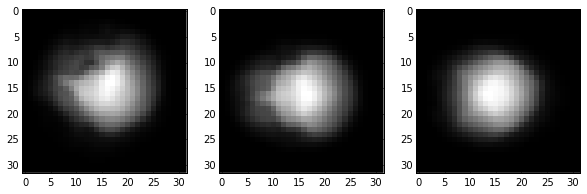

In [15]:
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol1_rot.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol1_rot.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Converged in 18 iterations!


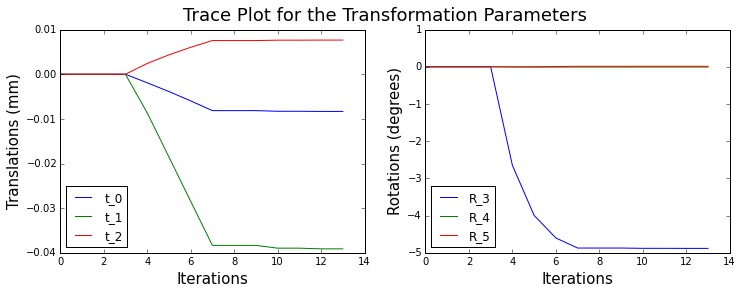

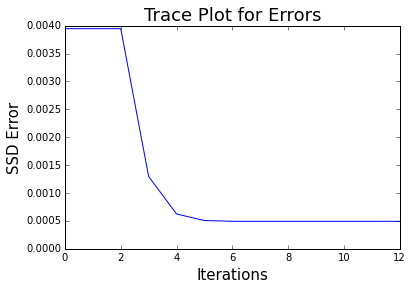

min error:  0.000492666811877
parameters at min error:  [-0.00104126 -0.0048895   0.00095663 -0.08519947 -0.00011854  0.00023785]
translation (in mm): [-0.00833006 -0.03911604  0.00765307]
rotations (in degrees): [-4.88157002 -0.00679157  0.01362771]


In [218]:
# 5 deg rotation in y axis
errors, Ps = Gauss_Newton(testVol1_rot,vol1_dervs_rot,testVol2_rot,vol2_dervs_rot,divide_factor = 16.,alpha=0.5,max_iter = 30)
print_results(errors, Ps, 8)

In [387]:
# Calculate the radius for masking
res = '8'
rot_ax = 'x'

# Get two volumes to register
testVol1_trans = get_volume(res,rot_ax,1,(0.0,0))
testVol2_trans = get_volume(res,rot_ax,1,(0.0,5))

vol1_dervs_trans = axis_derivatives(testVol1_trans)
vol2_dervs_trans = tricubic_derivatives(testVol2_trans)

In [250]:
print cf_ssd(testVol1_trans,testVol2_trans)
wx_t, wy_t, wz_t = ax_to_w(axes_dict[rot_ax])
print wx_t, wy_t, wz_t

trans = np.arange(-1,1,0.01)
cost = trans_cost_func_3d(testVol1_trans,testVol2_trans,trans,wx_t, wy_t, wz_t,3,True)
print np.min(cost)
print trans[np.argmin(cost)], 'voxel'
print trans[np.argmin(cost)]*8., 'mm'

0.00691082770955
0 0 -1
0.000713894558689
0.39 voxel
3.12 mm


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 Converged in 27 iterations!


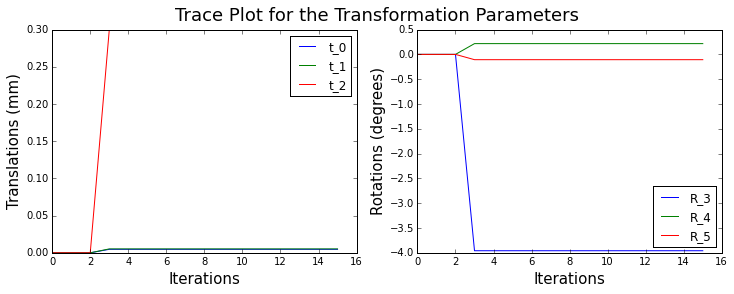

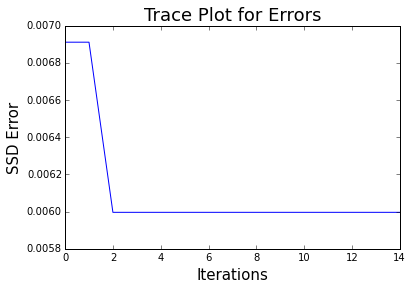

min error:  0.00599607500437
parameters at min error:  [ 0.00058473  0.0006547   0.03745139 -0.06908454  0.00379423 -0.00185869]
translation (in mm): [ 0.00467784  0.00523759  0.29961112]
rotations (in degrees): [-3.95825258  0.21739325 -0.10649534]


In [392]:
# 5 deg rotation in y axis
errors, Ps = Gauss_Newton(testVol1_trans,vol1_dervs_trans,testVol2_trans,vol2_dervs_trans, divide_factor = 16.,alpha=0.5,max_iter = 30)
print_results(errors, Ps, 8)

In [263]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

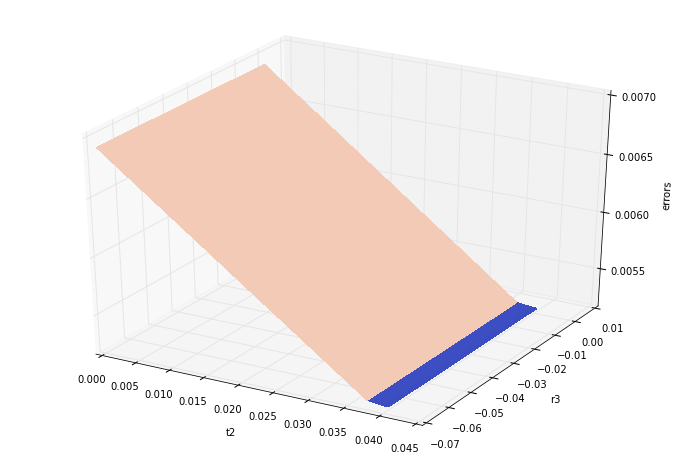

In [276]:
params_array = np.array(Ps)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
X = params_array[1:,2]
Y = params_array[1:,3]
X, Y = np.meshgrid(X, Y)
Z = errors[1:]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('t2')
ax.set_ylabel('r3')
ax.set_zlabel('errors')

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [12]:
# Calculate the radius for masking
res = '10'
rot_ax = 'x'

# Get two volumes to register
testVol1_trans_nomask = get_volume(res,rot_ax,1,(0.0,0),True)
testVol2_trans_nomask = get_volume(res,rot_ax,1,(0.0,5),False)

vol1_dervs_trans_nomask = axis_derivatives(testVol1_trans_nomask)
vol2_dervs_trans_nomask = tricubic_derivatives(testVol2_trans_nomask)

NameError: name 'get_volume' is not defined

In [418]:
P_s = np.array([0,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,vol2_dervs_trans_nomask,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(sphere_mask(dest,rad),testVol1_trans_nomask)

0.00691082770955


In [421]:
P_s = np.array([0,0,5./8.,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,vol2_dervs_trans_nomask,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(sphere_mask(dest,rad),testVol1_trans_nomask)

0.000234305786923


In [266]:
print cf_ssd(testVol1_trans_nomask,testVol2_trans_nomask)
wx_t, wy_t, wz_t = ax_to_w(axes_dict[rot_ax])
print wx_t, wy_t, wz_t

trans = np.arange(-1,1,0.01)
cost = trans_cost_func_3d(testVol1_trans_nomask,testVol2_trans_nomask,trans,wx_t, wy_t, wz_t,3,True)
print np.min(cost)
print trans[np.argmin(cost)], 'voxel'
print trans[np.argmin(cost)]*8., 'mm'

0.0465155165979
0 0 -1
0.000218809703264
0.61 voxel
4.88 mm


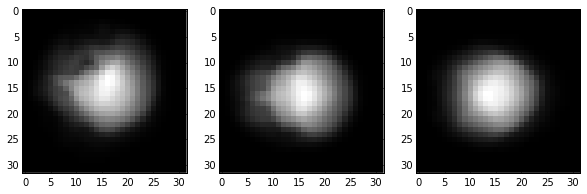

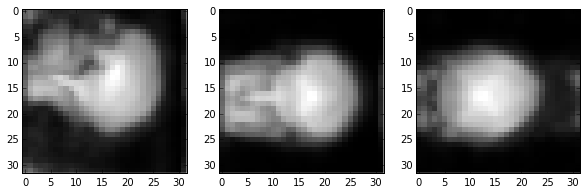

In [348]:
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol1_trans_nomask.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol2_trans_nomask.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 Converged in 19 iterations!


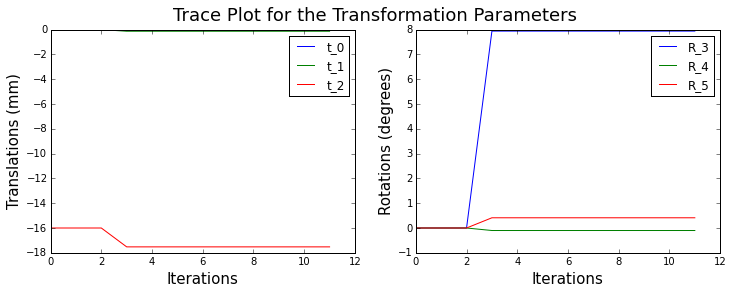

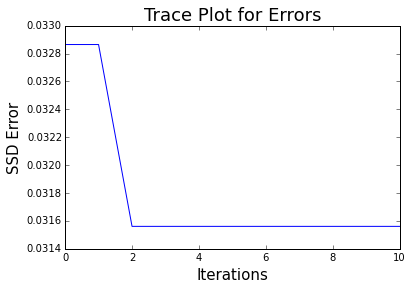

min error:  0.0315608328252
parameters at min error:  [ -1.24689760e-03  -1.64806779e-02  -2.19024365e+00   1.38586153e-01
  -1.76634409e-03   7.19282993e-03]
translation (in mm): [ -9.97518082e-03  -1.31845423e-01  -1.75219492e+01]
rotations (in degrees): [ 7.94040166 -0.10120406  0.4121188 ]


In [455]:
# 5 deg rotation in y axis
P_initial = np.array([0,0,-2,0,0,0])
errors, Ps = Gauss_Newton(testVol1_trans_nomask,vol1_dervs_trans_nomask,
                          testVol2_trans_nomask,vol2_dervs_trans_nomask, 
                          divide_factor = 16.,alpha=1.,P_initial = P_initial,max_iter = 30,mask=True)
print_results(errors, Ps, 8)

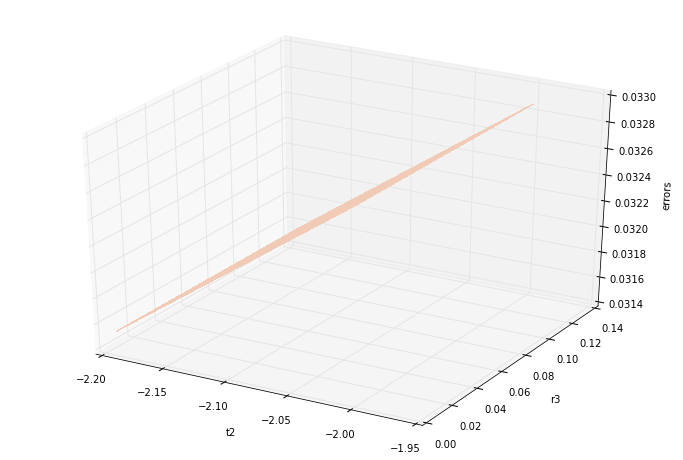

In [456]:
params_array = np.array(Ps)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
X = params_array[1:,2]
Y = params_array[1:,3]
X, Y = np.meshgrid(X, Y)
Z = errors[1:]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('t2')
ax.set_ylabel('r3')
ax.set_zlabel('errors')

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [11]:
def Gauss_Newton(Vol1, Vol1_derivatives, Vol2, Vol2_derivatives, 
                 divide_factor = 16., alpha = 0.2, decrease_factor = 0.25, 
                 P_initial = np.array([0,0,0,0,0,0]), plot = True, max_iter = 20, mask = False):

    volume_shape = Vol1.shape
    if (volume_shape[0] == 26): res = '10'
    if (volume_shape[0] == 32): res = '8'
    if (volume_shape[0] == 40): res = '6_4'
    rad = volume_shape[0]/2
    xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
    #if(mask):
        #Vol1 = sphere_mask(Vol1,rad)
    ox = volume_shape[1]/2.-0.5
    oy = volume_shape[0]/2.-0.5
    oz = volume_shape[2]/2.-0.5
    Ps = []
    P_old = P_initial.copy()
    P_new = P_old.copy()
    Ps.append(P_new)
    errors = []
    errors.append(1.0)
    
    for counter in xrange(max_iter):
        print counter,
        #print P_s
        P_old = P_new.copy()
        
        # Get the new coordinates by rotating the volume by the opposite amount of P_s
        dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, -1.*P_old, ox, oy, oz,divide_factor)
        #print dest_x
        # Initilization
        Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
        Jr_rP = np.zeros([6,])
        dest = np.empty(volume_shape)
        idx = 0
        #Mtensor = np.empty([volume_shape[0],volume_shape[0],volume_shape[0],3,6])
        for i in xrange(volume_shape[0]):
            for j in xrange(volume_shape[1]):
                for k in xrange(volume_shape[2]):
                    dest[i,j,k] = tricubic_interp(volume_shape,Vol2_derivatives,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k])
                    M = get_M(yy[i,j,k]-ox,xx[i,j,k]-oy,zz[i,j,k]-oz,divide_factor)
                    for ii in xrange(len(P_old)):
                        Jr[idx,ii] = -1.*Vol1_derivatives[i,j,k].dot(M[:,ii])
                    idx += 1
        if(mask):
            dest = sphere_mask(dest,rad)
        flatR = np.ravel(Vol1-dest)
        Jr_rP = Jr.T.dot(flatR)
        
        error = cf_ssd(Vol1,dest)

        ## if error is getting larger, go back one step and decrease alpha
        if(error > errors[-1]):
            alpha = alpha * decrease_factor
            P_new = Ps[-1]
        else:
            #print abs(error-errors[-1])
            errors.append(error)
            Ps.append(P_old)
            P_new = P_old - alpha*np.dot(np.linalg.inv(np.dot(Jr.T,Jr)),Jr_rP)
            if((abs(P_new - P_old) < 1e-5).all()):
                print 'Converged in %s iterations!' % counter
                break
    if(plot):
        trace_plot(Ps, float('.'.join(res.split('_'))))
        plot_errors(errors)
    return errors, Ps

In [248]:
from scipy import ndimage
def trans_cost_func_3d(vol1, vol2, trans, wx, wy, wz,order=1,mask = True):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    arg: string for plot titles
    '''
    if mask:
        rad = vol1.shape[0]/2
        vol1_masked = sphere_mask(vol1,rad)
    cost_func = np.zeros([len(trans),])
    for idx, t in enumerate(trans):
        new_vol2 = scipy.ndimage.interpolation.shift(vol2,np.array([wx,wy,wz])*t,order=order, mode='wrap')
        if mask:
            cost_func[idx] = cf_ssd(sphere_mask(new_vol2,rad),vol1_masked)
        else:
            cost_func[idx] = cf_ssd(new_vol2,vol1)
    return cost_func